In [1]:
import warnings
warnings.filterwarnings('ignore')

# Sklearn

## Bike sharing demand

Задача на kaggle: https://www.kaggle.com/c/bike-sharing-demand

По историческим данным о прокате велосипедов и погодным условиям необходимо оценить спрос на прокат велосипедов.

В исходной постановке задачи доступно 11 признаков: https://www.kaggle.com/c/prudential-life-insurance-assessment/data

В наборе признаков присутсвуют вещественные, категориальные, и бинарные данные.

## Библиотеки

In [2]:
from sklearn import model_selection, linear_model, metrics

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline 
sns.set(style="ticks")

In [3]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


## Загрузка данных

In [97]:
import zipfile
import os
def fetch_data(path):
    z = zipfile.ZipFile(path, 'r')
    z.extractall(path=os.path.join(".", "datasets"))
    z.close()

In [103]:
path = 'datasets/bike_sharing_demand.zip'
fetch_data(path)

In [4]:
raw_data = pd.read_csv('datasets/bike_sharing_demand.csv',sep=',')

In [5]:
raw_data.head()

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count
0,2011-01-01 00:00:00,1,0,0,1,9.84,14.395,81,0.0,3,13,16
1,2011-01-01 01:00:00,1,0,0,1,9.02,13.635,80,0.0,8,32,40
2,2011-01-01 02:00:00,1,0,0,1,9.02,13.635,80,0.0,5,27,32
3,2011-01-01 03:00:00,1,0,0,1,9.84,14.395,75,0.0,3,10,13
4,2011-01-01 04:00:00,1,0,0,1,9.84,14.395,75,0.0,0,1,1


**datetime** - hourly date + timestamp

**season** - 1 = spring, 2 = summer, 3 = fall, 4 = winter

**holiday** - whether the day is considered a holiday

**workingday** - whether the day is neither a weekend nor holiday

**weather** - 1: Clear, Few clouds, Partly cloudy, Partly cloudy 2: Mist + Cloudy, Mist + Broken clouds, Mist + Few clouds, Mist 3: Light Snow, Light Rain + Thunderstorm + Scattered clouds, Light Rain + Scattered clouds 4: Heavy Rain + Ice Pallets + Thunderstorm + Mist, Snow + Fog

**temp** - temperature in Celsius

**atemp** - "feels like" temperature in Celsius

**humidity** - relative humidity

**windspeed** - wind speed

**casual** - number of non-registered user rentals initiated

**registered** - number of registered user rentals initiated

**count** - number of total rentals

In [6]:
raw_data.shape

(10886, 12)

In [7]:
raw_data.isnull().values.any()

False

## Предобработка данных

### Типы признаков

In [8]:
raw_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10886 entries, 0 to 10885
Data columns (total 12 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   datetime    10886 non-null  object 
 1   season      10886 non-null  int64  
 2   holiday     10886 non-null  int64  
 3   workingday  10886 non-null  int64  
 4   weather     10886 non-null  int64  
 5   temp        10886 non-null  float64
 6   atemp       10886 non-null  float64
 7   humidity    10886 non-null  int64  
 8   windspeed   10886 non-null  float64
 9   casual      10886 non-null  int64  
 10  registered  10886 non-null  int64  
 11  count       10886 non-null  int64  
dtypes: float64(3), int64(8), object(1)
memory usage: 1020.7+ KB


Поменяем тип у *datetime*. С object-> datetime

In [9]:
raw_data.datetime = raw_data.datetime.apply(pd.to_datetime)
raw_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10886 entries, 0 to 10885
Data columns (total 12 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   datetime    10886 non-null  datetime64[ns]
 1   season      10886 non-null  int64         
 2   holiday     10886 non-null  int64         
 3   workingday  10886 non-null  int64         
 4   weather     10886 non-null  int64         
 5   temp        10886 non-null  float64       
 6   atemp       10886 non-null  float64       
 7   humidity    10886 non-null  int64         
 8   windspeed   10886 non-null  float64       
 9   casual      10886 non-null  int64         
 10  registered  10886 non-null  int64         
 11  count       10886 non-null  int64         
dtypes: datetime64[ns](1), float64(3), int64(8)
memory usage: 1020.7 KB


Создадим два новых признака: *месяц и час, когда это происходит*

In [10]:
raw_data['month'] = raw_data.datetime.apply(lambda x: x.month)
raw_data['hour'] = raw_data.datetime.apply(lambda x: x.hour)

In [11]:
raw_data.head()

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count,month,hour
0,2011-01-01 00:00:00,1,0,0,1,9.84,14.395,81,0.0,3,13,16,1,0
1,2011-01-01 01:00:00,1,0,0,1,9.02,13.635,80,0.0,8,32,40,1,1
2,2011-01-01 02:00:00,1,0,0,1,9.02,13.635,80,0.0,5,27,32,1,2
3,2011-01-01 03:00:00,1,0,0,1,9.84,14.395,75,0.0,3,10,13,1,3
4,2011-01-01 04:00:00,1,0,0,1,9.84,14.395,75,0.0,0,1,1,1,4


## Обучение и отложенный тест

Обучающая выборка для создания модели и обучения ее. Тестовая выборка - для проверки качества модели

In [12]:
train_data = raw_data.iloc[:-1000, :]
hold_out_test_data = raw_data.iloc[-1000:, :]

In [13]:
raw_data.shape, train_data.shape, hold_out_test_data.shape

((10886, 14), (9886, 14), (1000, 14))

In [14]:
print('train period from {} to {}'.format(train_data.datetime.min(), train_data.datetime.max()))
print('evaluation period from {} to {}'.format(hold_out_test_data.datetime.min(), hold_out_test_data.datetime.max()))

train period from 2011-01-01 00:00:00 to 2012-10-16 06:00:00
evaluation period from 2012-10-16 07:00:00 to 2012-12-19 23:00:00


## Данные и целевая функция

In [15]:
## обучение
train_labels = train_data['count'].values
train_data = train_data.drop(['datetime', 'count'], axis=1)
train_data.head()

,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,month,hour
0,1,0,0,1,9.84,14.395,81,0.0,3,13,1,0
1,1,0,0,1,9.02,13.635,80,0.0,8,32,1,1
2,1,0,0,1,9.02,13.635,80,0.0,5,27,1,2
3,1,0,0,1,9.84,14.395,75,0.0,3,10,1,3
4,1,0,0,1,9.84,14.395,75,0.0,0,1,1,4


In [16]:
## test
test_labels = hold_out_test_data['count'].values
test_data = hold_out_test_data.drop(['count', 'datetime'], axis=1)
test_data.head()

,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,month,hour
9886,4,0,1,1,17.22,21.210,67,6.0032,20,505,10,7
9887,4,0,1,1,18.04,21.970,62,0.0000,35,800,10,8
9888,4,0,1,1,19.68,23.485,55,16.9979,32,323,10,9
9889,4,0,1,1,20.50,24.240,48,19.0012,65,157,10,10
9890,4,0,1,1,20.50,24.240,45,27.9993,56,172,10,11


## Целевая функция на обучающей выборке и на отложенном тесте

Text(0.5, 1.0, 'test data')

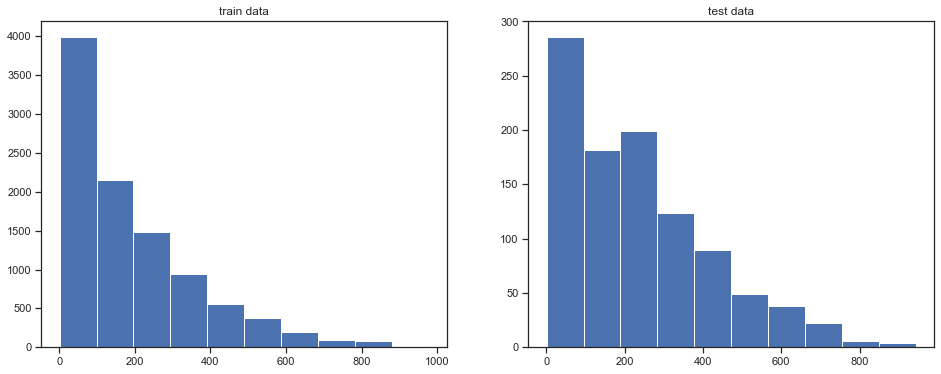

In [17]:
pylab.figure(figsize=(16,6))

pylab.subplot(1, 2, 1)
pylab.hist(train_labels)
pylab.title('train data')

pylab.subplot(1, 2, 2)
pylab.hist(test_labels)
pylab.title('test data')

## Числовые признаки

In [18]:
numeric_columns = ['temp', 'atemp', 'humidity', 'windspeed', 'casual', 'registered', 'month', 'hour']

In [19]:
train_data = train_data[numeric_columns]
test_data = test_data[numeric_columns]

In [20]:
train_data.head()

,temp,atemp,humidity,windspeed,casual,registered,month,hour
0,9.84,14.395,81,0.0,3,13,1,0
1,9.02,13.635,80,0.0,8,32,1,1
2,9.02,13.635,80,0.0,5,27,1,2
3,9.84,14.395,75,0.0,3,10,1,3
4,9.84,14.395,75,0.0,0,1,1,4


In [21]:
test_data.head()

,temp,atemp,humidity,windspeed,casual,registered,month,hour
9886,17.22,21.210,67,6.0032,20,505,10,7
9887,18.04,21.970,62,0.0000,35,800,10,8
9888,19.68,23.485,55,16.9979,32,323,10,9
9889,20.50,24.240,48,19.0012,65,157,10,10
9890,20.50,24.240,45,27.9993,56,172,10,11


## Модель

Так как у нас регрессия, то обучим регрессор.
Моделью будет регрессор на основе стохастического градиентного спуска

In [22]:
regressor = linear_model.SGDRegressor(random_state=0)

In [23]:
regressor.fit(train_data, train_labels)
metrics.mean_absolute_error(test_labels, regressor.predict(test_data))

32678333066101.656

Невероятно большая ошибка.

Посмотрим на истинные метки, и наши

In [24]:
test_labels[:10]

array([525, 835, 355, 222, 228, 325, 328, 308, 346, 446], dtype=int64)

In [25]:
regressor.predict(test_data)[:10]

array([-8.15217468e+13, -1.27940348e+14, -5.15430820e+13, -2.29149119e+13,
       -2.58255957e+13, -3.85635403e+13, -3.92648763e+13, -3.03104198e+13,
       -4.03846575e+13, -5.57515848e+13])

У нас очень плохие значения.

Посмотрим на наши коэффициенты.

In [26]:
print(list(map(lambda x: round(x, 2), regressor.coef_)))

[-23028547689.43, -587204401.77, -12729175530.75, -1273594091.93, 58373018311.46, -160478942389.07, -36745954823.9, -4870063728.49]


Коэффициенты просто нереальны. Это происходит из-за того, что мы не отмасштабировали признаки

## Scaling

In [27]:
from sklearn.preprocessing import StandardScaler

Создаем $scaler$

Чтобы применить наше преобразование, нужно сначала его обучить(то есть высчитать параметры $\mu$ и $\sigma$)

Обучать $scaler$ можно только на обучающей выборке(потому что часто на практике нам неизвестна тестовая выборка)

In [28]:
## создаем scaler
scaler = StandardScaler()
scaler.fit(train_data, train_labels)
scaled_trained_data = scaler.transform(train_data)
scaled_test_data = scaler.transform(test_data)

Теперь можно снова обучить модель

In [29]:
regressor.fit(scaled_trained_data, train_labels)
metrics.mean_absolute_error(test_labels, regressor.predict(scaled_test_data))

0.042930483012408885

**Ошибка получилось очень маленька**

Посмотрим на целефую функцию и наши прогнозы

In [30]:
test_labels[:10]

array([525, 835, 355, 222, 228, 325, 328, 308, 346, 446], dtype=int64)

In [31]:
regressor.predict(scaled_test_data)[:10]

array([524.90958201, 834.88816062, 354.94091402, 221.96933203,
       227.95283001, 324.96044934, 327.966113  , 307.98463956,
       345.96942383, 445.96231877])

### Мы ошибаемся меньше чем на 1 велосипед, это очень странно.

Посмотрим на коэффициенты

In [32]:
regressor.coef_

array([ 4.58902678e-01, -4.51836158e-01,  6.62608792e-04, -1.40703258e-02,
        5.08590377e+01,  1.48008168e+02, -1.32281341e-03,  7.59230341e-03])

In [33]:
print(list(map(lambda x: round(x, 2), regressor.coef_)))

[0.46, -0.45, 0.0, -0.01, 50.86, 148.01, -0.0, 0.01]


***Видно, что почти все признаки принимают маленькие коэффициенты, за исключением двух***.

Посмотрим на эти признаки

In [34]:
train_data.head()

,temp,atemp,humidity,windspeed,casual,registered,month,hour
0,9.84,14.395,81,0.0,3,13,1,0
1,9.02,13.635,80,0.0,8,32,1,1
2,9.02,13.635,80,0.0,5,27,1,2
3,9.84,14.395,75,0.0,3,10,1,3
4,9.84,14.395,75,0.0,0,1,1,4


Это признаки ***casual и registered***

In [35]:
train_labels[:10]

array([16, 40, 32, 13,  1,  1,  2,  3,  8, 14], dtype=int64)

Видно, что если сложить два эти признака, то получим целевую функцию

In [36]:
np.all(train_data.casual + train_data.registered == train_labels)

True

То есть мы использовали те данные, по которым однозначно восстанавливается целевая функция

Удалим из нашей выборки эти признаки

In [37]:
train_data.drop(['casual', 'registered'], axis=1, inplace=True)
test_data.drop(['casual', 'registered'], axis=1, inplace=True)

Отмасштабируем признаки на новом наборе данных.

И обучим модель

In [38]:
scaler.fit(train_data, train_labels)
scaled_train_data = scaler.transform(train_data)
scaled_test_data = scaler.transform(test_data)

In [39]:
regressor.fit(scaled_train_data, train_labels)
metrics.mean_absolute_error(test_labels, regressor.predict(scaled_test_data))

121.8835371361759

In [40]:
print(list(map(lambda x: round(x, 2), regressor.coef_)))

[30.01, 32.15, -42.28, 3.78, 12.71, 50.06]


Теперь видно, что почти все признаки вносят вклад в модель. Веса похожи на правильные

***Мы построили модель. Теперь попытаемся ее улучшить***

Для этого проведем кросс-валидацию. Но тут существует проблема: нам необходимо масштабировать данные. То есть нужно для каждого фолда провести масштабирование, а потом обучить его и проверить качество. Вся реализация будет очень громоздкой.

Благо, существует класс $Pipeline$

## Pipilene

In [41]:
from sklearn.pipeline import Pipeline

Вместо одного преобразования, $Pipeline$ позволяет делать целую цепочку преобразований

- каждый шаг представляется $tuple$

- первый элемент: название шага, второй элемент: объект, который способен преобразовывать данные

- ***главное, чтобы у объектов были такие методы как $fit$ и $transform$***

In [42]:
## создаем Pipeline из двух шагов: scaling и классификация
pipeline = Pipeline(steps=[('scaling', scaler), ('regression', regressor)])

In [43]:
pipeline.fit(train_data, train_labels)
metrics.mean_absolute_error(test_labels, pipeline.predict(test_data))

121.8835371361759

## Подбор параметров

Параметры будем подбирать по сетке

Посмотрим сначала как правильно к ним обращаться

In [44]:
pipeline.get_params().keys()

dict_keys(['memory', 'steps', 'verbose', 'scaling', 'regression', 'scaling__copy', 'scaling__with_mean', 'scaling__with_std', 'regression__alpha', 'regression__average', 'regression__early_stopping', 'regression__epsilon', 'regression__eta0', 'regression__fit_intercept', 'regression__l1_ratio', 'regression__learning_rate', 'regression__loss', 'regression__max_iter', 'regression__n_iter_no_change', 'regression__penalty', 'regression__power_t', 'regression__random_state', 'regression__shuffle', 'regression__tol', 'regression__validation_fraction', 'regression__verbose', 'regression__warm_start'])

In [45]:
parameters_grid = {
    'regression__loss' : ['huber', 'epsilon_insensitive', 'squared_loss', ],
    'regression__max_iter' : [3, 5, 10, 50], 
    'regression__penalty' : ['l1', 'l2', 'none'],
    'regression__alpha' : [0.0001, 0.01],
    'scaling__with_mean' : [0., 0.5],
}

Строим сетку

In [46]:
grid_cv = model_selection.GridSearchCV(pipeline, parameters_grid, scoring='neg_mean_absolute_error', cv=4)

Обучаем сетку

In [47]:
%%time
grid_cv.fit(train_data, train_labels)

Wall time: 10.9 s


GridSearchCV(cv=4,
             estimator=Pipeline(steps=[('scaling', StandardScaler()),
                                       ('regression',
                                        SGDRegressor(random_state=0))]),
             param_grid={'regression__alpha': [0.0001, 0.01],
                         'regression__loss': ['huber', 'epsilon_insensitive',
                                              'squared_loss'],
                         'regression__max_iter': [3, 5, 10, 50],
                         'regression__penalty': ['l1', 'l2', 'none'],
                         'scaling__with_mean': [0.0, 0.5]},
             scoring='neg_mean_absolute_error')

In [48]:
print(grid_cv.best_score_)
print(grid_cv.best_params_)

-108.61772632999148
{'regression__alpha': 0.01, 'regression__loss': 'squared_loss', 'regression__max_iter': 3, 'regression__penalty': 'l2', 'scaling__with_mean': 0.0}


## Оценка по отложенному тесту

In [49]:
metrics.mean_absolute_error(test_labels, grid_cv.best_estimator_.predict(test_data))

119.98978845935378

Наша ошибка теперь 120. То есть мы ошибаемся на 120 велосипедов

Посмотрим насколько наша ошибка большая, относительно среднего значения целевой переменной

In [50]:
np.mean(test_labels)

232.159

Это плохо

Раньше ошибка была 121, теперь 120. По сути, наша оптимизация нам никак не помогла, то есть мы никак не улучшили модель

Посмотрим на значения наших предсказаний

In [51]:
test_labels[:10]

array([525, 835, 355, 222, 228, 325, 328, 308, 346, 446], dtype=int64)

In [52]:
grid_cv.best_estimator_.predict(test_data)[:10]

array([139.60470681, 159.80765341, 207.55935972, 237.76288054,
       257.83836668, 267.44558034, 272.49537469, 297.70688522,
       304.29818873, 313.58821156])

Видно, что отличия довольно серьезные

Построим график наших предсказаний на целевой метке. Идеально было бы, если наши прогнозы и целевая метка совпадали и образовывали диагональ

(-100.0, 1100.0)

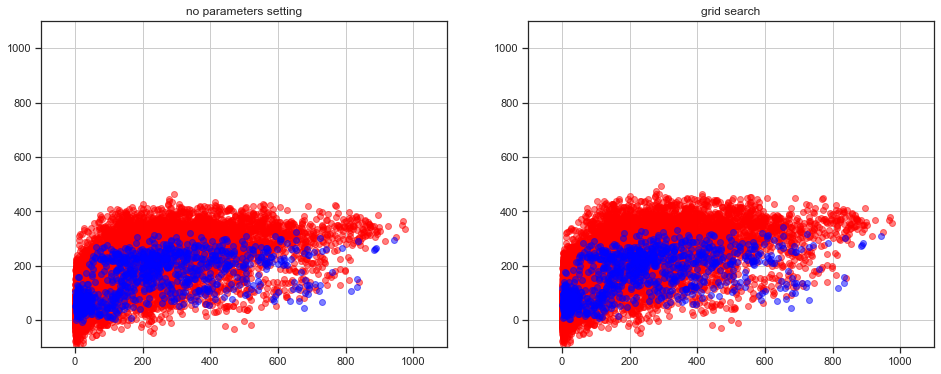

In [53]:
pylab.figure(figsize=(16,6))

pylab.subplot(1, 2, 1)
pylab.grid(True)
pylab.scatter(train_labels, pipeline.predict(train_data), alpha=0.5, color='red')
pylab.scatter(test_labels, pipeline.predict(test_data), alpha=0.5, color='blue')
pylab.title('no parameters setting')
pylab.xlim(-100, 1100)
pylab.ylim(-100, 1100)

pylab.subplot(1, 2, 2)
pylab.grid(True)
pylab.scatter(train_labels, grid_cv.best_estimator_.predict(train_data), alpha=0.5, color='red')
pylab.scatter(test_labels, grid_cv.best_estimator_.predict(test_data), alpha=0.5, color='blue')
pylab.title('grid search')
pylab.xlim(-100, 1100)
pylab.ylim(-100, 1100)

# SVM

In [54]:
from sklearn.svm import LinearSVR, SVR, NuSVR

### Объединяем отмасштабированные тренировачную и тестовую выборку в одну, чтобы показать на графике

In [55]:
columns = ['temp', 'atemp', 'humidity', 'windspeed', 'month', 'hour']
df_scaled_train_data = pd.DataFrame(scaled_train_data, columns=columns)
df_scaled_train_data.shape

(9886, 6)

In [56]:
df_scaled_test_data = pd.DataFrame(scaled_test_data, columns=columns)
df_scaled_test_data.shape

(1000, 6)

In [57]:
df_scaled_data = pd.concat((df_scaled_train_data, df_scaled_test_data))
df_scaled_data.shape

(10886, 6)

### Объединяем метки

In [58]:
labels = np.concatenate((train_labels,test_labels))
labels

array([ 16,  40,  32, ..., 168, 129,  88], dtype=int64)

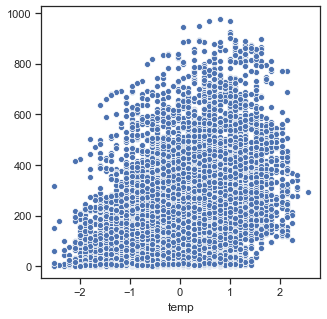

In [59]:
fig, ax = plt.subplots(figsize=(5,5)) 
sns.scatterplot(ax=ax, x=df_scaled_data.temp, y=labels)

In [60]:
def plot_regr(clf):
    title = clf.__repr__
    clf.fit(df_scaled_data, labels)
    y_pred = clf.predict(df_scaled_data)
    fig, ax = plt.subplots(figsize=(5,5))
    ax.set_title(title)
    ax.plot(df_scaled_data.temp, labels, 'b.')
    ax.plot(df_scaled_data.temp, y_pred, 'ro')
    plt.show()

1 : LinearSVR(max_iter=10000)


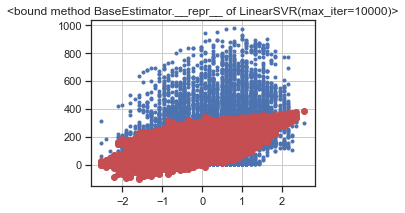

2 : LinearSVR(loss='squared_epsilon_insensitive', max_iter=10000)


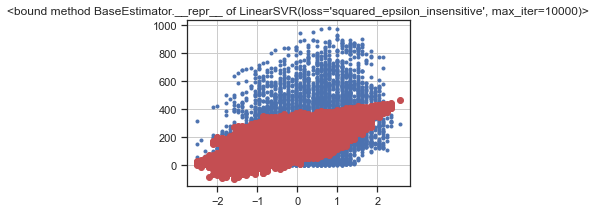

3 : SVR(kernel='linear')


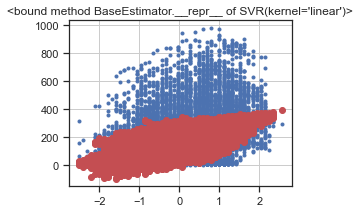

4 : SVR(gamma=0.2)


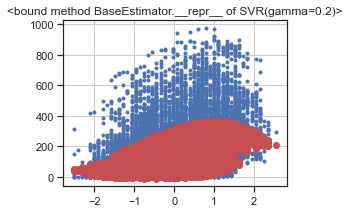

5 : SVR(gamma=0.8)


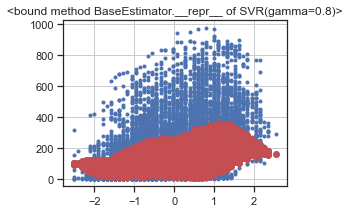

6 : NuSVR(gamma=0.8, nu=0.1)


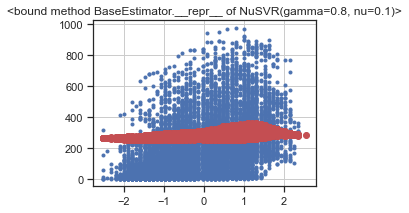

7 : NuSVR(gamma=0.8, nu=0.9)


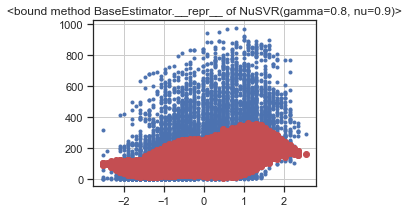

8 : SVR(degree=2, gamma='auto', kernel='poly')


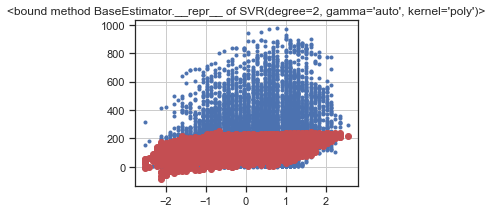

9 : SVR(gamma=0.2, kernel='poly')


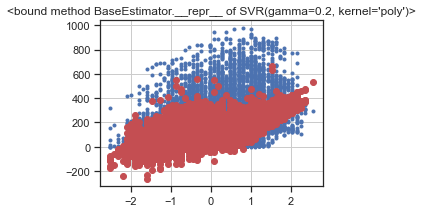

10 : SVR(degree=4, gamma=0.2, kernel='poly')


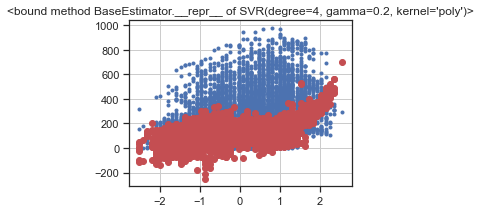

Wall time: 36.5 s


In [61]:
%%time
list_SVR = [LinearSVR(C=1.0, max_iter=10000), 
            LinearSVR(C=1.0, loss='squared_epsilon_insensitive', max_iter=10000), 
            SVR(kernel='linear', C=1.0),
           SVR(kernel='rbf', gamma=0.2, C=1.0),
           SVR(kernel='rbf', gamma=0.8, C=1.0),
           NuSVR(kernel='rbf', gamma=0.8, nu=0.1, C=1.0),
           NuSVR(kernel='rbf', gamma=0.8, nu=0.9, C=1.0),
           SVR(kernel='poly', degree=2, gamma='auto', C=1.0),
           SVR(kernel='poly', degree=3, gamma=0.2, C=1.0),
           SVR(kernel='poly', degree=4, gamma=0.2, C=1.0)]
for i, svm in enumerate(list_SVR):
    pylab.figure(figsize=(4,36))
    pylab.subplot(10, 1, i + 1)
    pylab.grid(True)
    svm.fit(df_scaled_data, labels)
    y_pred = svm.predict(df_scaled_data)
    plt.plot(df_scaled_data.temp, labels, 'b.')
    plt.plot(df_scaled_data.temp, y_pred, 'ro')
    print(i+1, ":", svm)
    pylab.title(svm.__repr__)
    plt.show()
#     plot_regr(svm)

In [62]:
def func():
    minimum = 100000.
    for i, svm in enumerate(list_SVR):
        svm.fit(scaled_train_data, train_labels)
        y_pred = svm.predict(scaled_test_data)
        print(str(i+1) + ") " + str(svm) + ":")
        MAE = metrics.mean_absolute_error(test_labels, y_pred)
        RMSE = np.sqrt(metrics.mean_squared_error(test_labels, y_pred))
        mean = (MAE + RMSE)/2.
        if float(mean) < float(minimum):
            minimum = mean
            best = (i+1, svm)
        print("MAE :", MAE)
        print("RMSE :", RMSE)
    print("The best is", best)

In [63]:
func()

1) LinearSVR(max_iter=10000):
MAE : 134.62885617780657
RMSE : 198.57231537501926
2) LinearSVR(loss='squared_epsilon_insensitive', max_iter=10000):
MAE : 121.48121298033922
RMSE : 179.07353807208273
3) SVR(kernel='linear'):
MAE : 133.54396132008895
RMSE : 197.17923535229073
4) SVR(gamma=0.2):
MAE : 127.24055811808151
RMSE : 191.65174247313433
5) SVR(gamma=0.8):
MAE : 137.55045579588213
RMSE : 199.4544677227705
6) NuSVR(gamma=0.8, nu=0.1):
MAE : 156.07688650425644
RMSE : 188.5885130216648
7) NuSVR(gamma=0.8, nu=0.9):
MAE : 137.15587625226325
RMSE : 198.99307771502586
8) SVR(degree=2, gamma='auto', kernel='poly'):
MAE : 147.45771621073627
RMSE : 201.40462758624605
9) SVR(gamma=0.2, kernel='poly'):
MAE : 135.64994483200658
RMSE : 196.1028204855855
10) SVR(degree=4, gamma=0.2, kernel='poly'):
MAE : 133.0989147717965
RMSE : 194.07532401041914
The best is (2, LinearSVR(loss='squared_epsilon_insensitive', max_iter=10000))


## При SVM мы все равно ошибаемся в среднем на 121 велосипед

# Random Forest

In [64]:
from sklearn.ensemble import RandomForestRegressor

In [65]:
regressor = RandomForestRegressor(random_state = 0, max_depth = 20, n_estimators = 50)

In [66]:
regressor.fit(train_data, train_labels)
y_pred = regressor.predict(test_data)

In [67]:
MAE = metrics.mean_absolute_error(test_labels, y_pred)
RMSE = np.sqrt(metrics.mean_squared_error(test_labels, y_pred))
print("MAE :", MAE)
print("RMSE :", RMSE)

MAE : 94.48785609748148
RMSE : 140.4009537401872


### Этот результат лучше, в среднем мы ошибаемся на 94 велосипеда.

In [68]:
pd.DataFrame([(pair[0], '{:.2f}'.format(pair[1])) for pair in zip(test_labels[:10], 
                                                                  list(map(lambda x: round(x, 2), y_pred[:10])))], columns=['Labels', 'Predictions'])

,Labels,Predictions
0,525,142.95
1,835,418.48
2,355,220.46
3,222,203.15
4,228,307.23
5,325,293.95
6,328,268.58
7,308,317.85
8,346,330.44
9,446,472.19


Text(0.5, 1.0, 'random forest model')

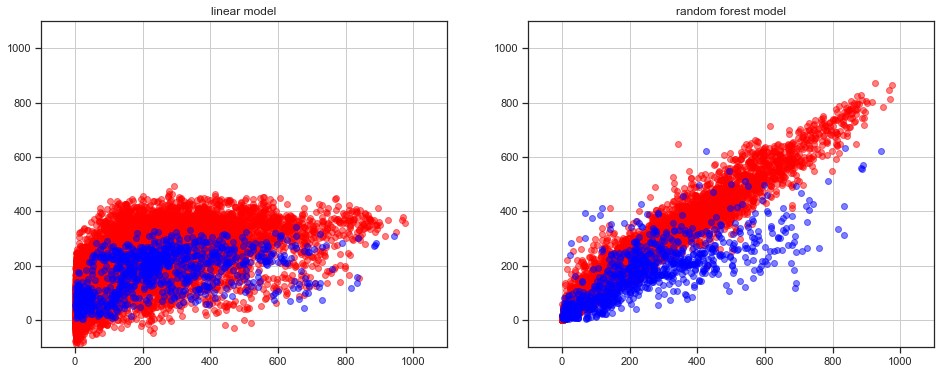

In [69]:
pylab.figure(figsize=(16, 6))

pylab.subplot(1,2,1)
pylab.grid(True)
pylab.xlim(-100,1100)
pylab.ylim(-100,1100)
pylab.scatter(train_labels, grid_cv.best_estimator_.predict(train_data), alpha=0.5, color = 'red')
pylab.scatter(test_labels, grid_cv.best_estimator_.predict(test_data), alpha=0.5, color = 'blue')
pylab.title('linear model')

pylab.subplot(1,2,2)
pylab.grid(True)
pylab.xlim(-100,1100)
pylab.ylim(-100,1100)
pylab.scatter(train_labels, regressor.predict(train_data), alpha=0.5, color = 'red')
pylab.scatter(test_labels, regressor.predict(test_data), alpha=0.5, color = 'blue')
pylab.title('random forest model')

In [70]:
from sklearn.tree import DecisionTreeRegressor, export_graphviz
from IPython.display import Image
try:
    from StringIO import StringIO
except ImportError:
    from io import StringIO
import pydotplus

In [71]:
# Визуализация дерева
def get_png_tree(tree_model_param, feature_names_param):
    dot_data = StringIO()
    export_graphviz(tree_model_param, out_file=dot_data, feature_names=feature_names_param,
                    filled=True, rounded=True, special_characters=True)
    graph = pydotplus.graph_from_dot_data(dot_data.getvalue())
    return graph.create_png()

In [72]:
# dot_data = export_graphviz(regressor)  
# graph = graphviz.Source(dot_data)  
# graph

In [73]:
decision_tree = DecisionTreeRegressor(random_state=42, max_depth=8)
decision_tree.fit(train_data, train_labels)
y_pred = decision_tree.predict(test_data)
metrics.mean_absolute_error(test_labels, y_pred)

93.38136635909738

In [75]:
# Image(get_png_tree(decision_tree, train_data.columns), height="500")

In [104]:
path = os.path.join('datasets', 'bike_sharing_demand.csv')
os.remove(path)

# Decision Tree or Random Forest - лучшие модели